<a href="https://colab.research.google.com/github/zeeba-tech/NLP/blob/main/recreating_llama_arch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

In [2]:
lines = open('./Shakespeare_data.csv', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

"Dataline","Play","PlayerLinen


In [3]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 78


'hello'

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

In [5]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([10188854])

In [6]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    'batch_size': 32,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('ttle valiant, gr', 'tle valiant, gre'),
 ('or measure","16"', 'r measure","16",'),
 ('se as she was wr', 'e as she was wri'),
 ('s Page?"\n"65669"', ' Page?"\n"65669",'),
 ('elp, friends bel', 'lp, friends belo'),
 (' tooth will rank', 'tooth will rankl'),
 ('MACBETH","We are', 'ACBETH","We are '),
 ('sin Margaret and', 'in Margaret and '),
 (',"As you like it', '"As you like it"'),
 ('death that lives', 'eath that lives '),
 ('6","CLEOPATRA","', '","CLEOPATRA","E'),
 ('177","Merchant o', '77","Merchant of'),
 ('battle, boy, and', 'attle, boy, and '),
 ('4106","Othello",', '106","Othello","'),
 ('USE","lost hair ', 'SE","lost hair o'),
 ('51542","King Lea', '1542","King Lear'),
 ('","of so much mo', ',"of so much mon'),
 ('e approbation of', ' approbation of '),
 ('"King Lear","52"', 'King Lear","52",'),
 (' as to know what', 'as to know what '),
 ('ntium. City,"\n"2', 'tium. City,"\n"27'),
 ('en","We\'ll hear ', 'n","We\'ll hear t'),
 ('Y V","Who serves', ' V","Who servest'),
 ('8"

In [7]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [8]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 36558


model params: 36558
validation loss:  4.065524578094482


<Axes: >

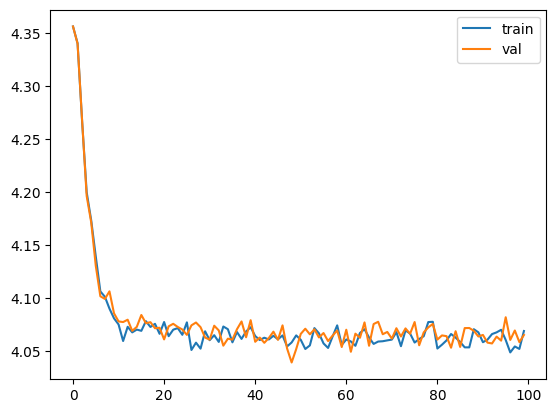

In [9]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(),
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

In [10]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\tyCF\'4"1iNAt1rjTP)LFZC.VFlWgHey',
 '\t)XVg,heAftHheJx)T EVU-YWPq(EGx',
 "\t\nVqq9Q!gRI)X'.IXajKCbni'2qvwKf",
 "\tJfqk7\nbf!5nJN\t-37cVg]'5O,Ap\nau",
 '\th\tGZBL!2HPC5:Pk5kJzd[-U-A\n:E-H']

In [11]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


In [12]:
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -.5)

# scaled_batch.var(dim=(1,2))
assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)


model params: 38606
validation loss:  2.4780203104019165


<Axes: >

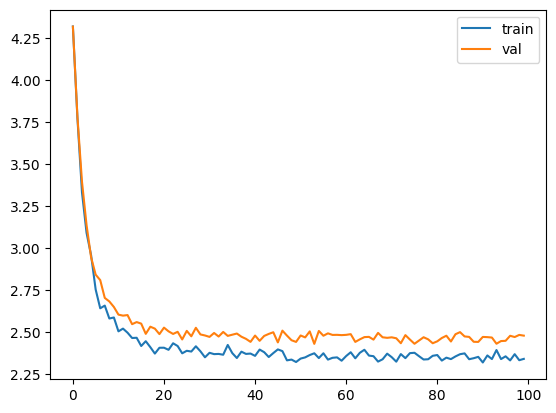

In [13]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Rotary embeddings

In [14]:
def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

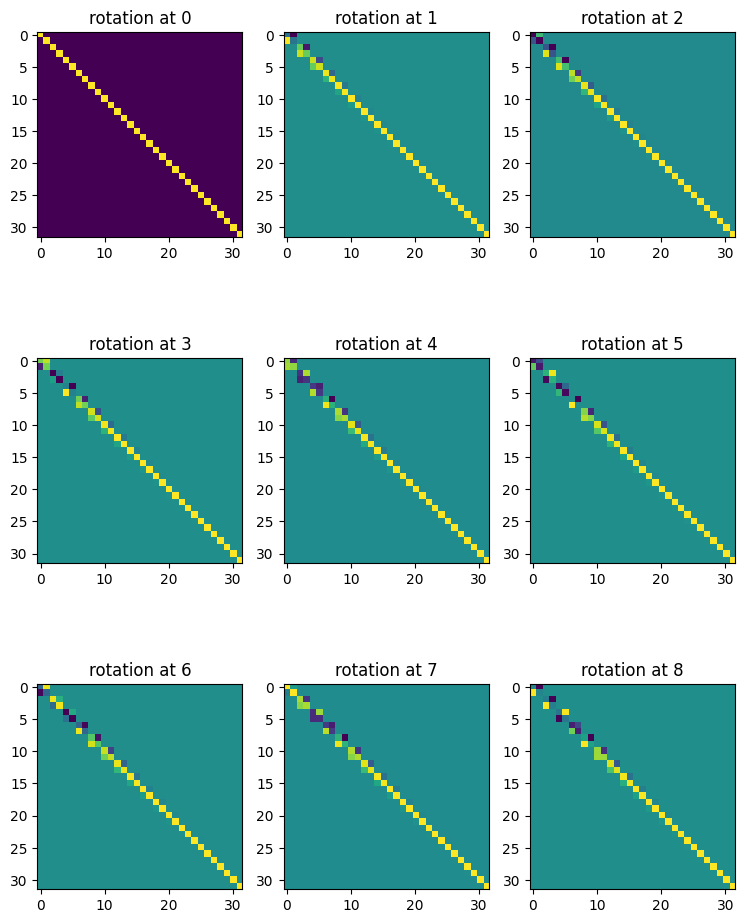

In [15]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [16]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

In [17]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R)).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R)).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R)).transpose(0,1)

        activations, attn_weights = self.multihead(
            q_out,k_out,v_out,
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [18]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])

q_out = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_out = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_out)

In [19]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}

layer = RoPEAttention(config)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0, m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m, :, :] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0, n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n, :, :] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k # transpose is redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)

<ipython-input-19-c1afcdad0490>:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  assert q.T @ k == q @ k # transpose is redundant


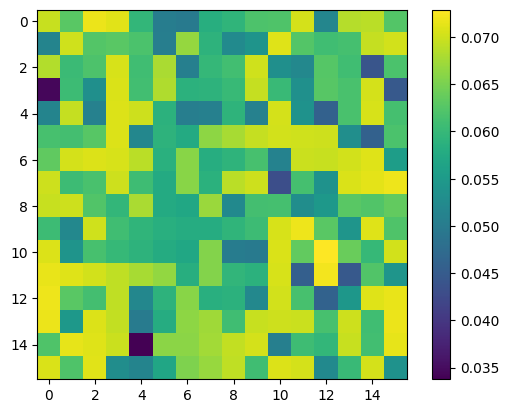

In [20]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()


In [21]:
class RoPEAttention_wMask(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R[:m, ...])).transpose(0,1)

        activations, attn_weights = self.multihead(
            q_out,k_out,v_out,
            attn_mask=nn.Transformer.generate_square_subsequent_mask(m),
            is_causal=True
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

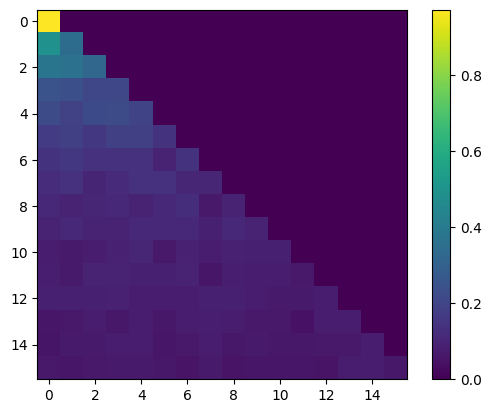

In [22]:
layer = RoPEAttention_wMask(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

model params: 153806
validation loss:  2.1016782999038695


<Axes: >

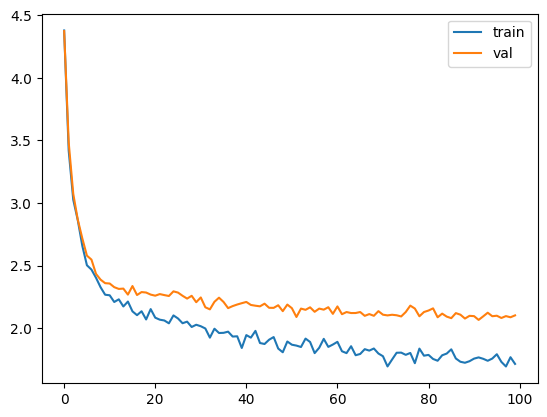

In [23]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)


validation loss:  1.932112193107605


<Axes: >

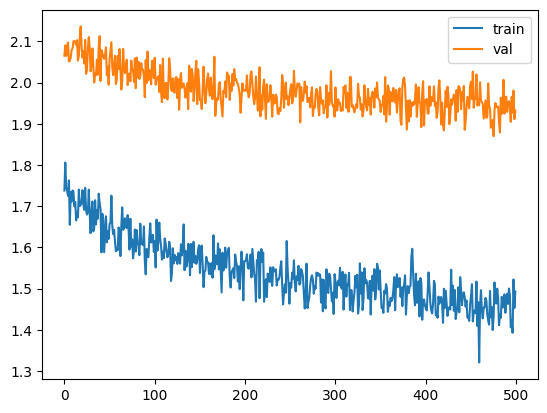

In [24]:
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})
train(model, optimizer)

SwisGLU

model params: 186831
validation loss:  2.0487902045249937


<Axes: >

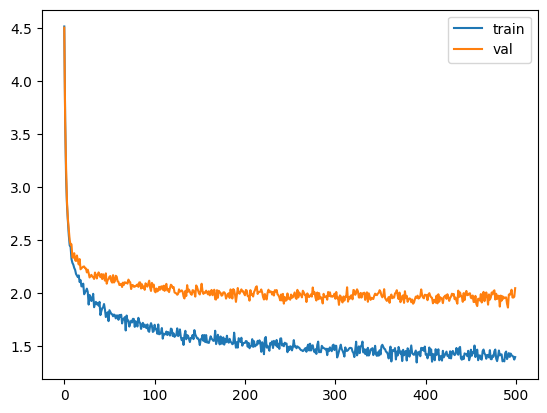

In [25]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [26]:
# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))

        self.attention = RoPEAttention_wMask(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

In [27]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']));

model params: 736723
validation loss:  1.9044236540794373


<Axes: >

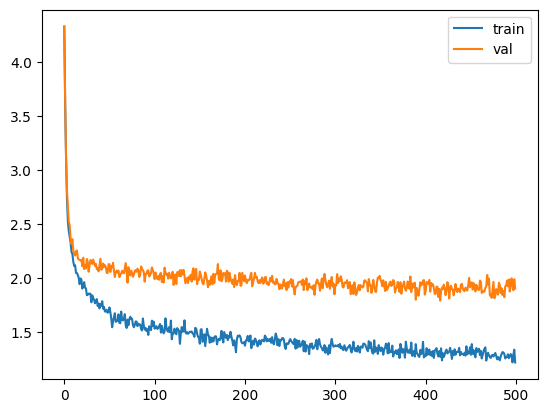

In [28]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)

validation loss:  1.3247668981552123


<Axes: >

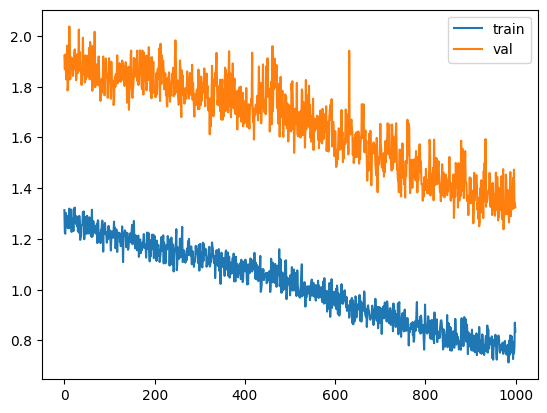

In [29]:
MASTER_CONFIG.update({
    'epochs': 10000,
})
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)


validation loss:  0.9840885400772095


<Axes: >

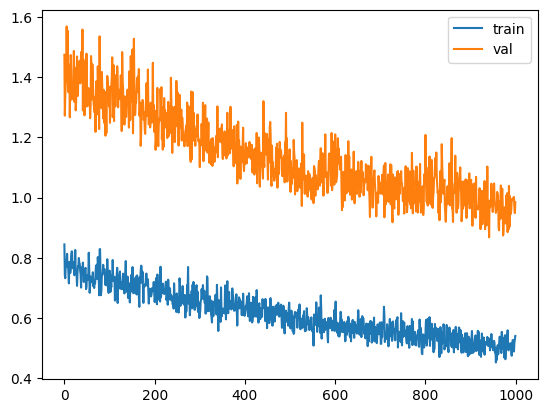

In [30]:
train(llama, optimizer, config=MASTER_CONFIG)

In [31]:
print(generate(llama, MASTER_CONFIG, 500)[0])

	Corio","2","4.6.5","HERATY","I makes wichful dreaming poy you,"
"24407","Coriolanus","5","3.5.57","WARWICK","Do nears"
"5032","Henry IV","20","2.4.16","1.37","LORD PANTE","Ry brould"
"83675","Romeo and Juliet","90","2.4.488","BEANIUS","Ha, seelfords, horis"
"62019","A Midsummer night","7","2.3.24","JULIET","Fllievirest id."
"40529","Othello","91",,"CORIO","Good nothise,"
"44218","King John","68","1.5.38","TYREY","I, you not"
"44031","Henry IV","3","2.2.122","Losst","Oreisth A vackel earter. Hy '


In [32]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = llama(xs, ys)

print(loss)

tensor(1.3016, grad_fn=<NllLossBackward0>)
